In [152]:
# Add project src to path.
import set_path

# Import modules.
import numpy as np
import time
import logging
import pandas as pd

# Visulatisation
%matplotlib widget
import matplotlib.pyplot as plt

import set_path
import src.utils.ahn_utils as ahn_utils
import src.utils.las_utils as las_utils
import src.utils.plot_utils as plot_utils
import src.utils.clip_utils as clip_utils

from pyntcloud import PyntCloud
import pandas as pd
from skimage import feature
from scipy import ndimage
import cv2 as cv

from shapely.geometry import LineString

import RANSAC

from skimage.transform import probabilistic_hough_line, hough_line, hough_line_peaks

#### Load Data

In [2]:
# Load data.
tilecode = '2386_9699'

# Labelled LAS file (see Notebook 0).
las_file = '../datasets/Valeriusplein/pointcloud/processed_' + tilecode + '.laz'
reduced_las_file = '../datasets/Valeriusplein/pointcloud/reduced_' + tilecode + '.laz'

# AHN data folder.
ahn_data_folder = '../datasets/Valeriusplein/ahn/'
# File with BGT building polygons.
bgt_building_file = '../datasets/Valeriusplein/bgt/bgt_buildings.csv'
# File with BGT road polygons.
bgt_road_file = '../datasets/Valeriusplein/bgt/bgt_roads.csv'
# File with <x,y> coordinates of pole-like objects.
bgt_pole_file = '../datasets/Valeriusplein/bgt/custom_poles.csv'
# File with <x,y> coordinates of street furniture objects.
bgt_street_furniture_file = '../datasets/Valeriusplein/bgt/bgt_street_furniture.csv'

# AHNReader for elevation data.
ahn_reader = ahn_utils.NPZReader(ahn_data_folder)

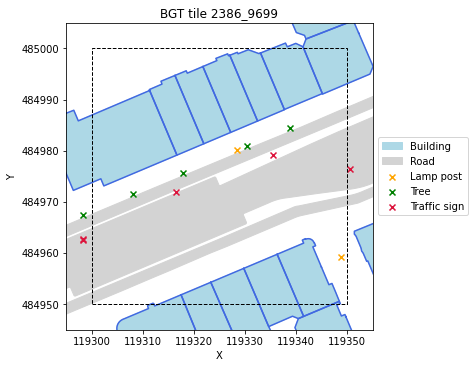

In [3]:
plot_utils.plot_bgt(tilecode, bgt_building_file, bgt_road_file, bgt_pole_file, bgt_street_furniture_file, padding=5)

## **Cable Extraction:** 2D projection

In [4]:
# true pointcloud
labeled_pointcloud = las_utils.read_las(las_file)
true_labels = labeled_pointcloud.label

# reduced pointcloud
pointcloud = las_utils.read_las(reduced_las_file)
points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
labels = pointcloud.label

# mask for unlabelled
mask = np.where(labels == 0)[0]

### 1. Voxelize

In [200]:
# 1. Voxelize
def voxelize(points, mask, voxel_size, logger=False):

    # Voxelize point cloud
    cloud = PyntCloud(pd.DataFrame(points[mask,:], columns=['x','y','z']))
    voxelgrid_id = cloud.add_structure("voxelgrid", size_x=voxel_size, size_y=voxel_size, size_z=voxel_size, regular_bounding_box=False)
    voxelgrid = cloud.structures[voxelgrid_id]
    if logger:
        print('Voxels per axis:',voxelgrid.x_y_z)
        print('Voxel size:',voxelgrid.shape)

    return voxelgrid

# 1. voxelize
voxel_size = 0.1
voxel_grid = voxelize(points, mask, voxel_size)

In [6]:
# # Unique voxel number for each point in the point cloud
# voxelgrid.voxel_n

# # Corresponding voxel per axis for each point in the point cloud
# voxelgrid.voxel_x, voxelgrid.voxel_y, voxelgrid.voxel_z

# # non-empty 26 neighbors of voxel
# voxelgrid.get_voxel_neighbors(874)

# # voxel centers by index
# voxelgrid.voxel_centers

# # Query point coords to voxel
# voxelgrid.query(points[mask,:][:10])

# # voxel grid values?
# voxelgrid.segments

# # Binary of cell is empty or not
# voxelgrid.get_feature_vector().shape

### 2. Top-Down Projection

In [ ]:
# 2. Top-down projection
def xy_projection(voxelgrid):
    voxelgrid_2d = voxelgrid.get_feature_vector().sum(axis=2)
    voxelgrid_2d = np.asarray(voxelgrid_2d > 0, dtype=int)
    return voxelgrid_2d

proj_2d = xy_projection(voxel_grid).astype('uint8')

### 3. Projection Filter

In [87]:
# Projection Filters
def culling(grid_projection, low_threshold=0, high_threshold=4, density=False):
    '''
    An empty space around cables is assumed, therefore dense cells surrounded with
    too many further dense cells can be concluded not being part of a cable. 
    Remove points with no or 3+ 8-neighbors.
    '''
    if not grid_projection.dtype == int:
        grid_projection = grid_projection.astype(int)
        
    k = np.array([[1,1,1],[1,0,1],[1,1,1]])
    cell_density = ndimage.convolve(grid_projection, k) * grid_projection
    if density:
        return cell_density
    return np.logical_and(cell_density < high_threshold, cell_density > low_threshold).astype(int)

def closing(grid_projection, n_iterations=1):
    '''
    Removes small holes in the foreground (dilation→erosion)
    '''
    return ndimage.binary_closing(grid_projection, iterations=n_iterations)

def closing_cv(img):
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3,3))
    return cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)

def erosion(grid_projection, n_iterations=1):
    '''
    Removes small holes in the foreground (dilation→erosion)
    '''
    return ndimage.binary_erosion(grid_projection, iterations=n_iterations)

def erode_cv(img):
    return cv.erode(img.copy(), None, iterations=1)

def canny_edge(grid_projection, sigma=0.5, low_threshold=0, high_threshold=1):
    '''
    Edge extraction algorithm (can also use openCV implementation)
    '''
    return feature.canny(grid_projection, sigma=sigma, low_threshold=low_threshold, high_threshold=high_threshold)

def apply_filters(grid_projection, filters):
    grid = grid_projection.copy()
    for filter in filters:
        if filter[0] == 'culling':
            grid = culling(grid, filter[1], filter[2])
        elif filter[0] == 'closing':
            grid = closing(grid, filter[1])
        elif filter[0] == 'edge':
            grid = canny_edge(grid, filter[1])
        elif filter[0] == 'erosion':
            grid = erosion(grid, filter[1])

    return grid

# 3. High-density / vegetaion filters
proj_2d_processed = apply_filters(proj_2d, [['closing',3],['edge',0.5],['closing',2],['erosion',1]]).astype('uint8')

In [10]:
# OpenCV Canny implementatie
# (mu, sigma) = cv.meanStdDev(img)
# cv.Canny(proj_2d.astype('uint8'), np.double(mu - sigma), np.double(mu + sigma))

##### Projection Filter Analysis

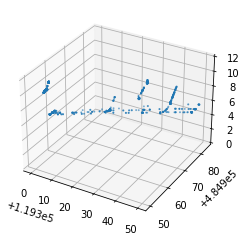

In [99]:
proc_mask = proj_2d_processed[tuple(voxel_grid.voxel_x), tuple(voxel_grid.voxel_y)].astype(bool)
missed_mask = true_labels[mask[~proc_mask]]==11

fig = plt.figure()
ax = plt.axes(projection='3d')
plt_points = points[mask[~proc_mask]][missed_mask]
ax.scatter(plt_points[:, 0], plt_points[:, 1], plt_points[:, 2], s=1, label='missed cable points')
ax.set_zlim((0,12))
plt.show()

Filter Processor 1
	No. voxels: 2351, cable points lost 24.36%
Filter Processor 2
	No. voxels: 2592, cable points lost 12.91%
Filter Processor 3
	No. voxels: 2551, cable points lost 13.13%
Filter Processor 4
	No. voxels: 2697, cable points lost 12.87%


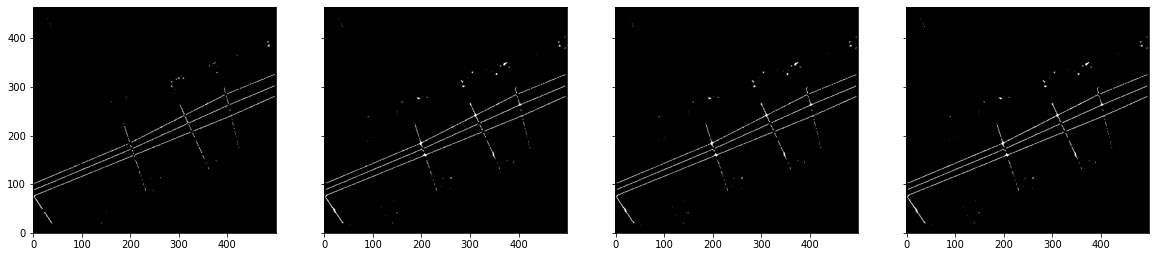

In [86]:
processed_projections = []
processed_projections.append(apply_filters(proj_2d, [['closing',2],['edge',0.5],['closing',1],['erosion',1]]).astype('uint8'))
processed_projections.append(apply_filters(proj_2d, [['closing',3],['edge',0.5],['closing',2],['erosion',1]]).astype('uint8'))
processed_projections.append(apply_filters(proj_2d, [['closing',3],['edge',0.45],['closing',2],['erosion',1]]).astype('uint8'))
n_proj = len(processed_projections)

for i in range(n_proj):
    processed_proj = processed_projections[i]
    proc_mask = processed_proj[tuple(voxel_grid.voxel_x), tuple(voxel_grid.voxel_y)].astype(bool)

    total_voxels = np.sum(processed_proj)
    per_cable_points =  round(100 - 100 * np.sum(true_labels[mask[proc_mask]]==11)/np.sum(true_labels[mask]==11),2)

    print(f'Filter Processor {i+1}')
    print(f'\tNo. voxels: {total_voxels}, cable points lost {per_cable_points}%')

# plotting
fig, ax = plt.subplots(1, n_proj, figsize=(20,10) ,sharex=True, sharey=True)
for i in range(n_proj):
    ax[i].imshow(processed_projections[i].T, cmap='gray')
    ax[i].autoscale(False)
    ax[i].invert_yaxis()



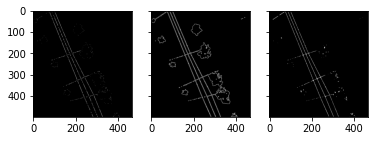

In [8]:
fig, ax = plt.subplots(1,3, sharex=True, sharey=True)
ax[0].imshow(apply_filters(voxelgrid_2d, ['closing','closing','culling']), cmap='gray')
ax[1].imshow(apply_filters(voxelgrid_2d, ['closing','closing','edge']), cmap='gray')
ax[2].imshow(apply_filters(voxelgrid_2d, ['closing','edge','closing','erosion']), cmap='gray')

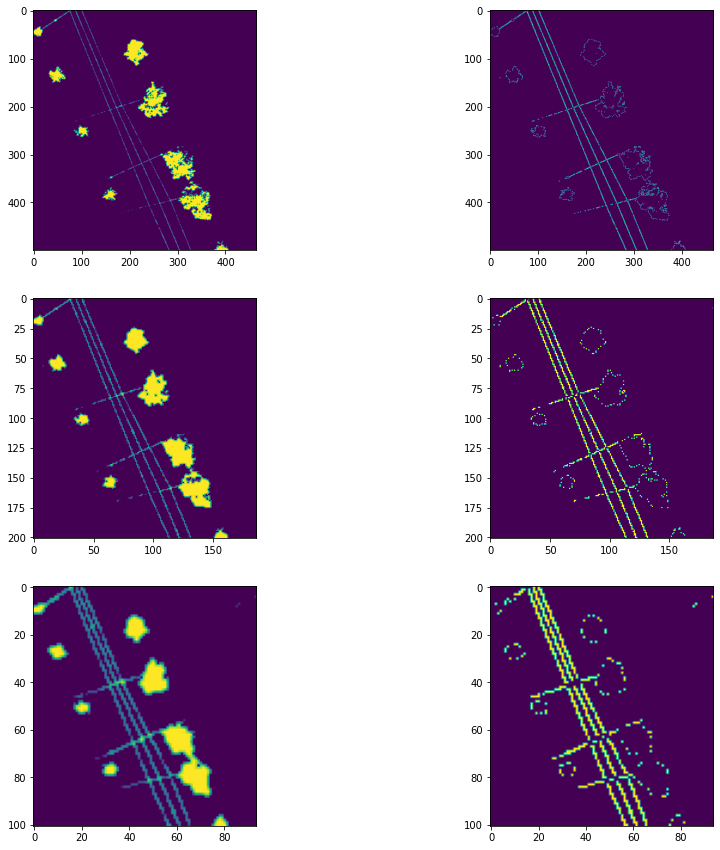

In [9]:
fig, axes = plt.subplots(3,2, figsize=(15,15))
ax = axes.ravel()

# voxel size 0.1
pc_exp = voxelize(points, mask, 0.1)
proj_exp = xy_projection(pc_exp)
proj_exp_culling_map = culling(proj_exp, density=True)
proj_exp_culled = culling(proj_exp, high_threshold=5)
ax[0].imshow(proj_exp_culling_map)
ax[1].imshow(proj_exp_culled)

# voxel size 0.25
pc_exp = voxelize(points, mask, 0.25)
proj_exp = xy_projection(pc_exp)
proj_exp_culling_map = culling(proj_exp, density=True)
proj_exp_culled = culling(proj_exp, high_threshold=5)
ax[2].imshow(proj_exp_culling_map)
ax[3].imshow(proj_exp_culled)

# voxel size 0.5
pc_exp = voxelize(points, mask, 0.5)
proj_exp = xy_projection(pc_exp)
proj_exp_culling_map = culling(proj_exp, density=True)
proj_exp_culled = culling(proj_exp, high_threshold=5)
ax[4].imshow(proj_exp_culling_map)
ax[5].imshow(proj_exp_culled)

##### Culling Analysis
If the _voxelsize_ is set too small, and the neighbouring threshold too low. Cables and object attached to cables can be recognised as high point density area and so removed.

### 4. Hough Transform

In [88]:
def line_points(x, x0, y0, slope):
    return y0 + slope * (x - x0)

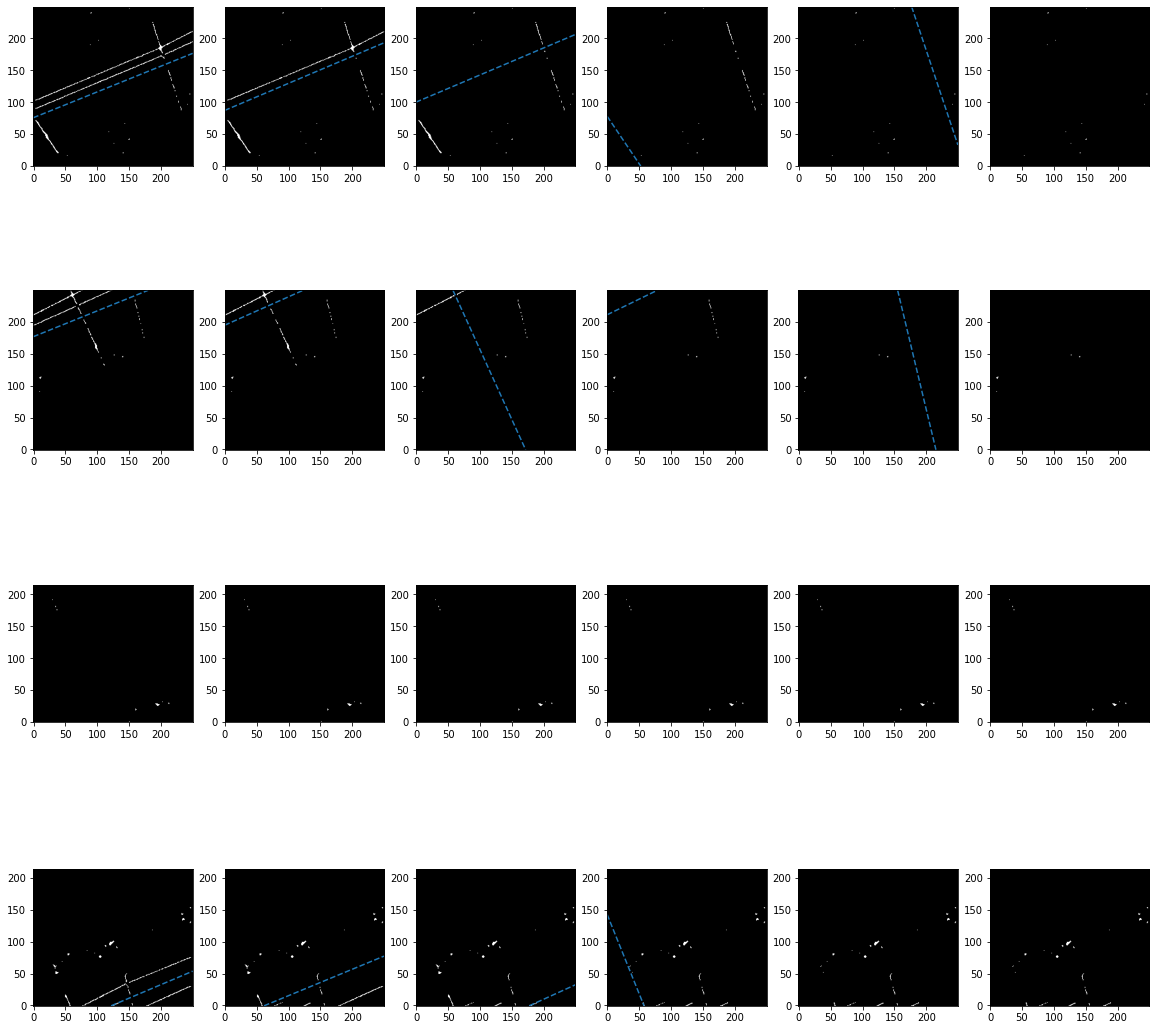

In [89]:
lines_segments = []

fig, axes = plt.subplots(4,6, figsize=(20,20))
ax = axes.ravel()

# Tile Sections
limits = [(0,0),(250,0),(0,250),(250,250)]
for s in range(4):
    
    # Get tile selection
    x_limit = limits[s][0]
    y_limit = limits[s][1]
    proj_2d_selection = proj_2d_processed[x_limit:x_limit+250, y_limit:y_limit+250,].copy()
    n_x = proj_2d_selection.shape[0]

    # Line detection iterations
    for iter in range(6):
        lines = cv.HoughLines(proj_2d_selection, 1, np.pi / 360, 20)

        if not lines is None:
            line = lines[0][0]
            (rho, theta) = line

            # Convert to line points
            x0 = np.sin(theta) * rho
            y0 = np.cos(theta) * rho
            slope = 1 / np.tan(theta + np.pi/2)

            # Remove line points from section
            x = np.arange(n_x)
            y = np.round(line_points(x, x0, y0, slope)).astype(int)
            for i in range(n_x):
                if not y[i]-4 < 0:
                    proj_2d_selection[i,y[i]-5:y[i]+6] = 0

            # Save line
            xy0, xy1 = (x[0]+x_limit, y[0]+y_limit), (x[-1]+x_limit, y[-1]+y_limit)
            lines_segments.append([xy0, xy1])

            # Plot line
            ax[iter+s*6].axline((x0, y0), slope=slope, linestyle='--')

        ax[iter+s*6].imshow(proj_2d_selection.T, cmap='gray')
        ax[iter+s*6].autoscale(False)
        ax[iter+s*6].invert_yaxis()

#### Hough Analysis

In [63]:
# proj_2d_section = proj_2d_processed[:100, :100]


# fig, axes = plt.subplots(1, 5, figsize=(20,10))
# ax = axes.ravel()

# for i in range(5):
#     ax[i].imshow(proj_2d_section, cmap='gray')
#     ax[i].set_title('Original, i='+str(i*15))
#     if i > 0:
#         lines = cv.HoughLines(proj_2d_section, 1, np.pi / 180, i*15)

#         for line in lines:
#             rho = line[0][0]
#             theta = line[0][1]
#             a = np.cos(theta)
#             b = np.sin(theta)
#             x0 = a*rho
#             y0 = b*rho
#             ax[i].axline((x0, y0), slope=np.tan(theta + np.pi/2))
#     ax[i].set_ylim((100,0))
        


### 5. Cable extraction: 3D-RANSAC

In [122]:

# Morphologies
process_mask = proj_2d_processed[tuple(voxel_grid.voxel_x), tuple(voxel_grid.voxel_y)].astype(bool)

# Convert tile lines to coordinates
lines = np.array(lines_segments) * voxel_size
lines[:,:,0] = lines[:,:,0] + voxel_grid.xyzmin[0]
lines[:,:,1] = lines[:,:,1] + voxel_grid.xyzmin[1]

cable_segements = []

for line in lines:

    # Create Shapely line
    shapely_line = LineString(line)

    # Vertical cut with buffer of 25cm on both sides
    poly = shapely_line.buffer(.25)
    clip_mask = clip_utils.poly_clip(points[mask][process_mask], poly)
    v_cut_points = points[mask][process_mask][clip_mask]

    # RANSAC 3D Catenary Fit
    ransac_3d = RANSAC.Line()
    model_robust, inliers, pt_samples = ransac_3d.fit(v_cut_points, residual_threshold=.25, max_trials=500)
    outliers = inliers == False
    cable_inlier_mask = mask[process_mask][clip_mask][inliers]
    # cable_segements.append(cable_inlier_mask)

    # Refit with more points
    # Vertical cut with buffer of 25cm on both sides
    clip_mask = clip_utils.poly_clip(points[mask], poly)
    v_cut_points = points[mask][clip_mask]

    inliers = ransac_3d.inlier_outlier(v_cut_points, residual_threshold=.2)
    outliers = inliers == False
    cable_inlier_mask = mask[clip_mask][inliers]
    cable_segements.append(cable_inlier_mask)

    # plot Ransac Cut
    plot_fit = False
    if plot_fit:
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.scatter(v_cut_points[inliers][:, 0], v_cut_points[inliers][:, 1], v_cut_points[inliers][:, 2], c='b', label='Inlier data')
        ax.scatter(v_cut_points[outliers][:, 0], v_cut_points[outliers][:, 1], v_cut_points[outliers][:, 2], c='r', marker='o', label='Outlier data')
        ax.legend(loc='lower left')
        plt.show()

In [123]:
fig = plt.figure()
ax = plt.axes(projection='3d')
i=1
for cable_segment in cable_segements:
    cable_points = points[cable_segment]
    ax.scatter(cable_points[:, 0], cable_points[:, 1], cable_points[:, 2], s=1, label='Cable '+str(i))
    i+=1

ax.set_zlim((0,12))
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [126]:
cable_point_ids = np.unique(np.hstack(cable_segements))

n_labelled = len(cable_point_ids)
TP = np.sum(true_labels[cable_point_ids]==11)
FP = np.sum(true_labels[cable_point_ids]!=11)
TN = np.sum(true_labels!=11) - FP
FN = np.sum(true_labels==11) - TP

precision = round(100*TP/(TP+FP),2)
correctness = round(100*TP/(TP+FN),2)
acccuracy = round(100*(TP+TN)/(TP+TN+FP+FN),2)

print(f'Accuracy: {acccuracy}% | Precision: {precision}% | Correctness: {correctness}%')

print(f'\nTotal labelled as cable point: {n_labelled}')
print(f'- Correctly labelled: {round(100*TP/n_labelled,2)}%')
print(f'Missed cable points: {FN} ({round(100*FN/(FN+TP),2)}%)')


Accuracy: 99.96% | Precision: 98.43% | Correctness: 89.31%

Total labelled as cable point: 7715
- Correctly labelled: 98.43%
Missed cable points: 909 (10.69%)


In [37]:
labels[cable_mask] = 11
out_file = '../datasets/Valeriusplein/pointcloud/exp_A_' + tilecode + '.laz'
las_utils.label_and_save_las(pointcloud, labels, out_file)